<a href="https://colab.research.google.com/github/Ripa-Shah/Analyzing-Social-Sentiment-Data-to-determine-correlation-with-Cryptocurrency-Price/blob/main/MIS584_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS584 Lab Assignment 3
## Learning Objectives
* Demonstrate the understanding of **streaming data collection**
* Demonstrate the understanding of **Kafka architecture**
* Demonstrate the capability of **reading API documents for formulating API requests**

## Due Date
**Check D2L for the Due Dates**

## Assignment Submission Instructions
When your file is ready, submit the following deliverables to the Lab Assignmen 3 dropbox:
* Provide the link to your Google Colab notebook in the comments section; please make sure that **you enable the general access to your notebook with links before submission**.
* Upload the notebook file with the `.ipynb` suffix to the submission drop box. The uploaded notebook should have the same content as the one shared through the link, include enough documentation of the code, and have all the outputs available.
* Upload the CSV file that stores all the collected Wiki recent changes information you collected for Part 2 of this lab assignment.

## Others
As always, feel free to come to our office hours or let us know through email if you face any difficulties/challenges while finishing the assignment. Good luck! For your convenience, I have created the text and code cells you might need for the lab assignment. Please also complete your contact information in the notebook as well.

You will notice that, in this Lab Assignment, there are not many "empty" spaces where you need to fill your own code. Instead, the main objective is to let you explore the streaming data, Kafka environment, and API documents and successfully follow the exercises (with some parameter adjustments).

## Student's Contact Information:
Name: Ripa Shah

Email: ripashah@arizona.edu

## Part 1: Stream Data Pipeline Exercise using Apache Kafka (3.5 Points)

Please review and practice ```MIS584_Kafka_StockPrice.ipynb``` under Module 3: [https://colab.research.google.com/drive/1NUSe0Pue2UL3i3fN1SDEYcYZolXQTGya?usp=sharing](https://colab.research.google.com/drive/1NUSe0Pue2UL3i3fN1SDEYcYZolXQTGya?usp=sharing)

* Select a ticker (e.g., UBER, SBUX, etc) with your own interest, collect stock price data for the ticker, and generate moving-average plots.
  * You don't have to provide plots for every single new data points as in the lab session Colab, i.e., you may adjust the interval between the two consecutive plots.
* Modify period, interval, or other available parameters based on you preference. yfinance takes the following parameters as input:
  * **period**: data period to download (either use period parameter or use start and end) Valid periods are:
“1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”.
  * **interval**: data interval (1m data is only for available for last 7 days, and data interval <1d for the last 60 days) Valid intervals are:
“1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”.
  * **start**: If not using period - in the format (yyyy-mm-dd) or datetime.
  * **end**: If not using period - in the format (yyyy-mm-dd) or datetime.
  * Please visit the following link for details: [yfinance Library – A Complete Guide](https://algotrading101.com/learn/yfinance-guide/#:~:text=interval%3A%20data%20interval%20(1m%20data,%E2%80%9C1mo%E2%80%9D%2C%20%E2%80%9C3mo%E2%80%9D)

### Solution for Lab Assignment 3 Part 1
Please replace this sentence with the documentation of your code for Lab Assignment 3 Part 1.

In [11]:
"""
This code cell is for Lab Assignment 3 Part 1
"""

!pip install pyspark
!pip install sseclient
!pip install kafka-python

  Preparing metadata (setup.py) ... done
  Created wheel for sseclient: filename=sseclient-0.0.27-py3-none-any.whl size=5563 sha256=4944cc22a5eae66cc4c4946f0ba82b9323e0dd2264532a709366a3ac6e6b41d7
  Stored in directory: /root/.cache/pip/wheels/31/92/90/140c622b64ef3858608d5bbceb950fc169553911f32c2eca19
Successfully built sseclient
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 4.8 MB/s eta 0:00:00


In [12]:
# the code below mounts your google drive to /content/drive folder
# you might need to provide authorizations using your google account
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [13]:
import os
from datetime import datetime
import time
import threading
import json
import kafka
from kafka import KafkaProducer
from kafka.errors import KafkaError
import requests
from sseclient import SSEClient as EventSource

In [14]:
# Download Apache Kafka and unzip into your Google Colab session.
!curl -sSOL https://archive.apache.org/dist/kafka/3.1.0/kafka_2.13-3.1.0.tgz
!tar -xzf kafka_2.13-3.1.0.tgz

In [15]:
# start zookeeper server & kafka server set $KAFKA_HOME variable path in bashrc (i.e., a configuration file for the Bash shell).
!./kafka_2.13-3.1.0/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.1.0/config/zookeeper.properties #--override delete.topic.enable=true
!./kafka_2.13-3.1.0/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.1.0/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [16]:
# see if kafka properties are shown in the results.
!ps -ef | grep kafka

root       24230       1 19 22:56 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.1.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.1.0/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.1.0/bin/../config/log4j.properties -cp /content/kafka_2.13-3.1.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.1.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.1.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

In [20]:
pip install yfinance pandas


In [21]:
!pip install avro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 2.0 MB/s eta 0:00:00


In [22]:
import time
import json
import kafka
from kafka import KafkaProducer
from kafka.errors import KafkaError
import io
import avro.schema
from avro.io import DatumWriter

In [25]:
# create topics
# define producer
topic = 'AMAZON'
bootstrap_server = "localhost:9092"
producer = kafka.KafkaProducer(
    bootstrap_servers=[bootstrap_server]
)

In [26]:
# stock_dict = df["High"].to_dict().items()
stock_dict = df['High', 'AMZN'].to_dict().items()

In [27]:
for keys,values in stock_dict:
    print(keys)
    print(values)

2024-11-15 00:00:00
207.33999633789062
2024-11-18 00:00:00
204.6699981689453
2024-11-19 00:00:00
205.3000030517578
2024-11-20 00:00:00
203.1300048828125
2024-11-21 00:00:00
203.49000549316406
2024-11-22 00:00:00
199.25999450683594
2024-11-25 00:00:00
201.9499969482422
2024-11-26 00:00:00
208.0
2024-11-27 00:00:00
207.63999938964844
2024-11-29 00:00:00
208.1999969482422
2024-12-02 00:00:00
212.99000549316406
2024-12-03 00:00:00
214.02000427246094
2024-12-04 00:00:00
220.0
2024-12-05 00:00:00
222.14999389648438
2024-12-06 00:00:00
227.14999389648438
2024-12-09 00:00:00
230.0800018310547
2024-12-10 00:00:00
229.05999755859375
2024-12-11 00:00:00
231.1999969482422
2024-12-12 00:00:00
231.08999633789062
2024-12-13 00:00:00
230.1999969482422
2024-12-16 00:00:00
233.0
2024-12-17 00:00:00
232.72999572753906
2024-12-18 00:00:00
231.39999389648438
2024-12-19 00:00:00
226.08999633789062
2024-12-20 00:00:00
226.2100067138672
2024-12-23 00:00:00
226.8800048828125
2024-12-24 00:00:00
229.13999938964

In [33]:
# With Schema
SCHEMA_PATH = "/content/stock_schema.avsc"
SCHEMA = avro.schema.parse(open(SCHEMA_PATH).read())

'''
{
	"namespace": "stock_schema.avro",
	"type": "record",
	"name": "Stock",
	"fields": [
		{"name": "name", "type": "string"},
		{"name": "time",  "type": "string"},
		{"name": "price", "type": "float"}
	]
}
'''

'\n{\n\t"namespace": "stock_schema.avro",\n\t"type": "record",\n\t"name": "Stock",\n\t"fields": [\n\t\t{"name": "name", "type": "string"},\n\t\t{"name": "time",  "type": "string"},\n\t\t{"name": "price", "type": "float"}\n\t]\n}\n'

In [34]:
import yfinance as yf


amazon = yf.Ticker("AMZN")

ticker = 'AMZN'
df = yf.download(tickers=ticker, period='1y', interval='1d')

df.head(100)

print(df.columns)

## In many cases, we define the functions like below to "write to kafka" for specific topics using producer.
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  global count
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message in items:

        bytes_writer = io.BytesIO()
        encoder = avro.io.BinaryEncoder(bytes_writer)

        writer = DatumWriter(SCHEMA)
        data = {
            "name": ticker,
            "time": message[0].strftime('%Y-%m-%d %H:%M:%S'),
            "price": message[1]
        }
        writer.write(data, encoder)

        raw_bytes = bytes_writer.getvalue()
        print(data, raw_bytes)
        # producer.send(topic_name)
        producer.send(topic_name, raw_bytes)
        # producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
        count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))





/tmp/ipython-input-992555730.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=ticker, period='1y', interval='1d')
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'AMZN'),
            (  'High', 'AMZN'),
            (   'Low', 'AMZN'),
            (  'Open', 'AMZN'),
            ('Volume', 'AMZN')],
           names=['Price', 'Ticker'])


In [35]:
write_to_kafka(topic, stock_dict)


{'name': 'AMZN', 'time': '2024-11-15 00:00:00', 'price': 207.33999633789062} b'\x08AMZN&2024-11-15 00:00:00\nWOC'


{'name': 'AMZN', 'time': '2024-11-18 00:00:00', 'price': 204.6699981689453} b'\x08AMZN&2024-11-18 00:00:00\x85\xabLC'
{'name': 'AMZN', 'time': '2024-11-19 00:00:00', 'price': 205.3000030517578} b'\x08AMZN&2024-11-19 00:00:00\xcdLMC'
{'name': 'AMZN', 'time': '2024-11-20 00:00:00', 'price': 203.1300048828125} b'\x08AMZN&2024-11-20 00:00:00H!KC'
{'name': 'AMZN', 'time': '2024-11-21 00:00:00', 'price': 203.49000549316406} b'\x08AMZN&2024-11-21 00:00:00q}KC'
{'name': 'AMZN', 'time': '2024-11-22 00:00:00', 'price': 199.25999450683594} b'\x08AMZN&2024-11-22 00:00:00\x8fBGC'
{'name': 'AMZN', 'time': '2024-11-25 00:00:00', 'price': 201.9499969482422} b'\x08AMZN&2024-11-25 00:00:003\xf3IC'
{'name': 'AMZN', 'time': '2024-11-26 00:00:00', 'price': 208.0} b'\x08AMZN&2024-11-26 00:00:00\x00\x00PC'
{'name': 'AMZN', 'time': '2024-11-27 00:00:00', 'price': 207.63999938964844} b'\x08AMZN&2024-11-27 00:00:00\xd7\xa3OC'
{'name': 'AMZN', 'time': '2024-11-29 00:00:00', 'price': 208.1999969482422} b'\x08AMZN

In [36]:
# Moving Average Periods (in hours/periods)
SMA_SHORT_WINDOW = 5
SMA_LONG_WINDOW = 20

/tmp/ipython-input-497510809.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
/tmp/ipython-input-497510809.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices[f'{SMA_SHORT_WINDOW}h_SMA'] = close_prices['Close'].rolling(window=SMA_SHORT_WINDOW).mean()
/tmp/ipython-input-497510809.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices[f'{SMA_LONG_WINDOW}h_SMA'] = close_prices['Close'].rolling(window=SMA_LONG_WINDOW).mean()


Moving Averages Calculated.


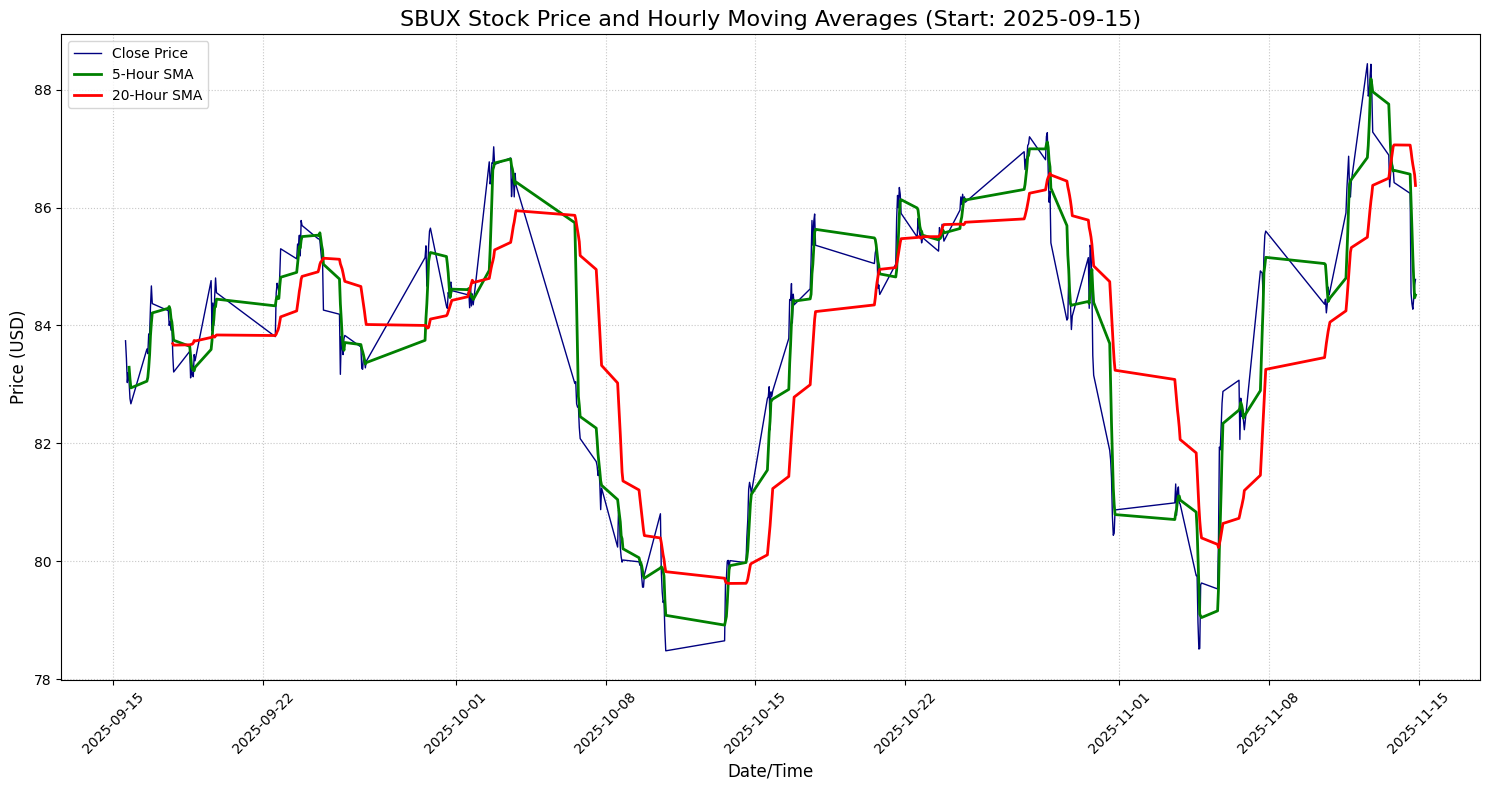


Successfully generated plot for SBUX with 1h data.


In [38]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Configuration: Ticker and yfinance Parameters ---
ticker_symbol = "SBUX"
interval_selection = "1h"
start_date = "2025-09-15"
end_date = None # Defaults to the current date

# Moving Average Periods (in hours/periods)
SMA_SHORT_WINDOW = 5
SMA_LONG_WINDOW = 20

# --- 2. Collect Stock Price Data ---
print(f"Downloading {ticker_symbol} data: {start_date} to today (Interval: {interval_selection})...")

try:
    # Download the historical data using start and end dates instead of 'period'
    data = yf.download(
        ticker_symbol,
        start=start_date,
        interval=interval_selection,
        progress=False)
    if data.empty:
        print("Error: No data retrieved. Check the ticker symbol and date/interval constraints.")
    else:
        # Keep only the 'Close' price
        close_prices = data[['Close']]

        # --- 3. Calculate Moving Averages (Simple Moving Average - SMA) ---
        close_prices[f'{SMA_SHORT_WINDOW}h_SMA'] = close_prices['Close'].rolling(window=SMA_SHORT_WINDOW).mean()
        close_prices[f'{SMA_LONG_WINDOW}h_SMA'] = close_prices['Close'].rolling(window=SMA_LONG_WINDOW).mean()

        print("Moving Averages Calculated.")

        # --- 4. Generate Moving-Average Plot ---
        plt.figure(figsize=(15, 8))

        # Plot the original Close Price
        plt.plot(close_prices['Close'], label='Close Price', color='navy', linewidth=1.0)

        # Plot the Moving Averages
        plt.plot(close_prices[f'{SMA_SHORT_WINDOW}h_SMA'], label=f'{SMA_SHORT_WINDOW}-Hour SMA', color='green', linewidth=2.0)
        plt.plot(close_prices[f'{SMA_LONG_WINDOW}h_SMA'], label=f'{SMA_LONG_WINDOW}-Hour SMA', color='red', linewidth=2.0)

        # Set plot title and labels
        plt.title(f'{ticker_symbol} Stock Price and Hourly Moving Averages (Start: {start_date})', fontsize=16)
        plt.xlabel('Date/Time', fontsize=12)
        plt.ylabel('Price (USD)', fontsize=12)

        # Add legend and grid
        plt.legend(loc='upper left')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.xticks(rotation=45) # Rotate x-axis labels for better visibility
        plt.tight_layout() # Adjust plot to fit rotated labels

        # Display the plot
        plt.show()

        print(f"\nSuccessfully generated plot for {ticker_symbol} with {interval_selection} data.")

except Exception as e:
    print(f"An error occurred during data processing: {e}")

## Part 2: Streaming Data and Kafka: Data Storage and Visualization (3.5 Points)

Please go through and practice ```MIS584_StreamingData_and_Kafka.ipynb``` under Module 3: [https://colab.research.google.com/drive/1arGNR58NPUFgKmk4fUTwjsyQaSXKPOhV?usp=sharing](https://colab.research.google.com/drive/1arGNR58NPUFgKmk4fUTwjsyQaSXKPOhV?usp=sharing)

* Click the following link to explore how the Wikipedia "recent changes" streaming data looks like (scrolling down to the end is challenging as the velocity of new data is high!): [https://stream.wikimedia.org/v2/stream/recentchange](https://stream.wikimedia.org/v2/stream/recentchange)
* To simulate an application generating events for Kafka, this simple Python producer application is created that reads events from Wikipedia and sends them to the wiki-changes Kafka topic.
  * This Colab exercise (1) saves the collected streaming data into a CSV file and (2) generates a sorted bar plot of Top 20 Users who have modified Wikipedia pages most frequently during the streaming duration of 30 seconds.
* Similarly, your tasks are to
  * (1) save the collected data into a CSV file, just like the example in the instruction.
  * (2) define your own ```streaming_duration```, select your own fields of interest (e.g., ```server_name```, ```bot```, etc.) and tabulate/plot the summary of collected data.
  * Explore [Wikimedia EventStreams API](https://stream.wikimedia.org/?doc#/streams), [MediaWiki Manual:RCFeed](https://www.mediawiki.org/wiki/Manual:RCFeed), and other links provided in the Colab for details.
  * This is an open-ended question, so please feel free to experiment with different ways!





### Solution for Lab Assignment 3 Part 2
Please replace this sentence with the documentation of your code for Lab Assignment 3 Part 2.

***You may create a separate ipynb file if that's more convenient because of conflicts in SparkContext, Producer, Consumer, etc. of Part 1.***

In [45]:
"""
This code cell is for Lab Assignment 3 Part 2
"""
#pip install kafka-python requests pandas matplotlib

import requests
import json
import time
from kafka import KafkaProducer

# --- CONFIGURATION ---
STREAM_URL = "https://stream.wikimedia.org/v2/stream/recentchange"
KAFKA_BROKER = 'localhost:9092'  # Update if your broker is different
KAFKA_TOPIC = 'wiki-changes'
STREAMING_DURATION = 60  # seconds

# Initialize Kafka Producer
producer = KafkaProducer(
    bootstrap_servers=[KAFKA_BROKER],
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

print(f"Starting Wikipedia Producer for topic '{KAFKA_TOPIC}'...")

def stream_to_kafka(duration):
    """Collects events and sends them to Kafka."""
    start_time = time.time()
    events_sent = 0

    try:
        with requests.get(STREAM_URL, stream=True, timeout=duration + 10) as response:
            if response.status_code == 200:
                for line in response.iter_lines():
                    if time.time() - start_time > duration:
                        break

                    if line.startswith(b'data:'):
                        try:
                            # Parse JSON event data
                            event_data = json.loads(line.decode('utf-8')[5:].strip())

                            # Send the event to the Kafka topic
                            producer.send(KAFKA_TOPIC, value=event_data)
                            events_sent += 1

                        except json.JSONDecodeError:
                            continue
            else:
                print(f"Error connecting to stream: Status code {response.status_code}")

    except requests.exceptions.RequestException as e:
        print(f"Producer stream error: {e}")
    finally:
        # Ensure all buffered messages are sent before exiting
        producer.flush()
        print(f"\nProducer finished. Total events sent to Kafka: {events_sent}")


# --- Execution ---
if __name__ == "__main__":
    stream_to_kafka(STREAMING_DURATION)

Starting Wikipedia Producer for topic 'wiki-changes'...
Error connecting to stream: Status code 403

Producer finished. Total events sent to Kafka: 0
